# Cryto price forecasting using Autoformer 

In [11]:
#Importamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
from transformers import AutoModel, AutoTokenizer  # Ajusta según la disponibilidad del modelo Autoformer
from datetime import datetime
import ta



In [15]:
#Obtener el dataset
data = pd.read_csv('BTC-USD.csv', parse_dates=['Date'])
data.set_index('Date', inplace=True)
data


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,1.856566e+10
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,2.080208e+10
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,2.811148e+10
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,1.844427e+10
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,1.972507e+10
...,...,...,...,...,...,...
2024-04-19,63510.750000,65481.597656,59651.390625,63843.570313,63843.570313,4.992043e+10
2024-04-20,63851.101563,65442.457031,63172.402344,64994.441406,64994.441406,2.309749e+10
2024-04-21,64992.816406,65723.242188,64277.722656,64926.644531,64926.644531,2.050664e+10


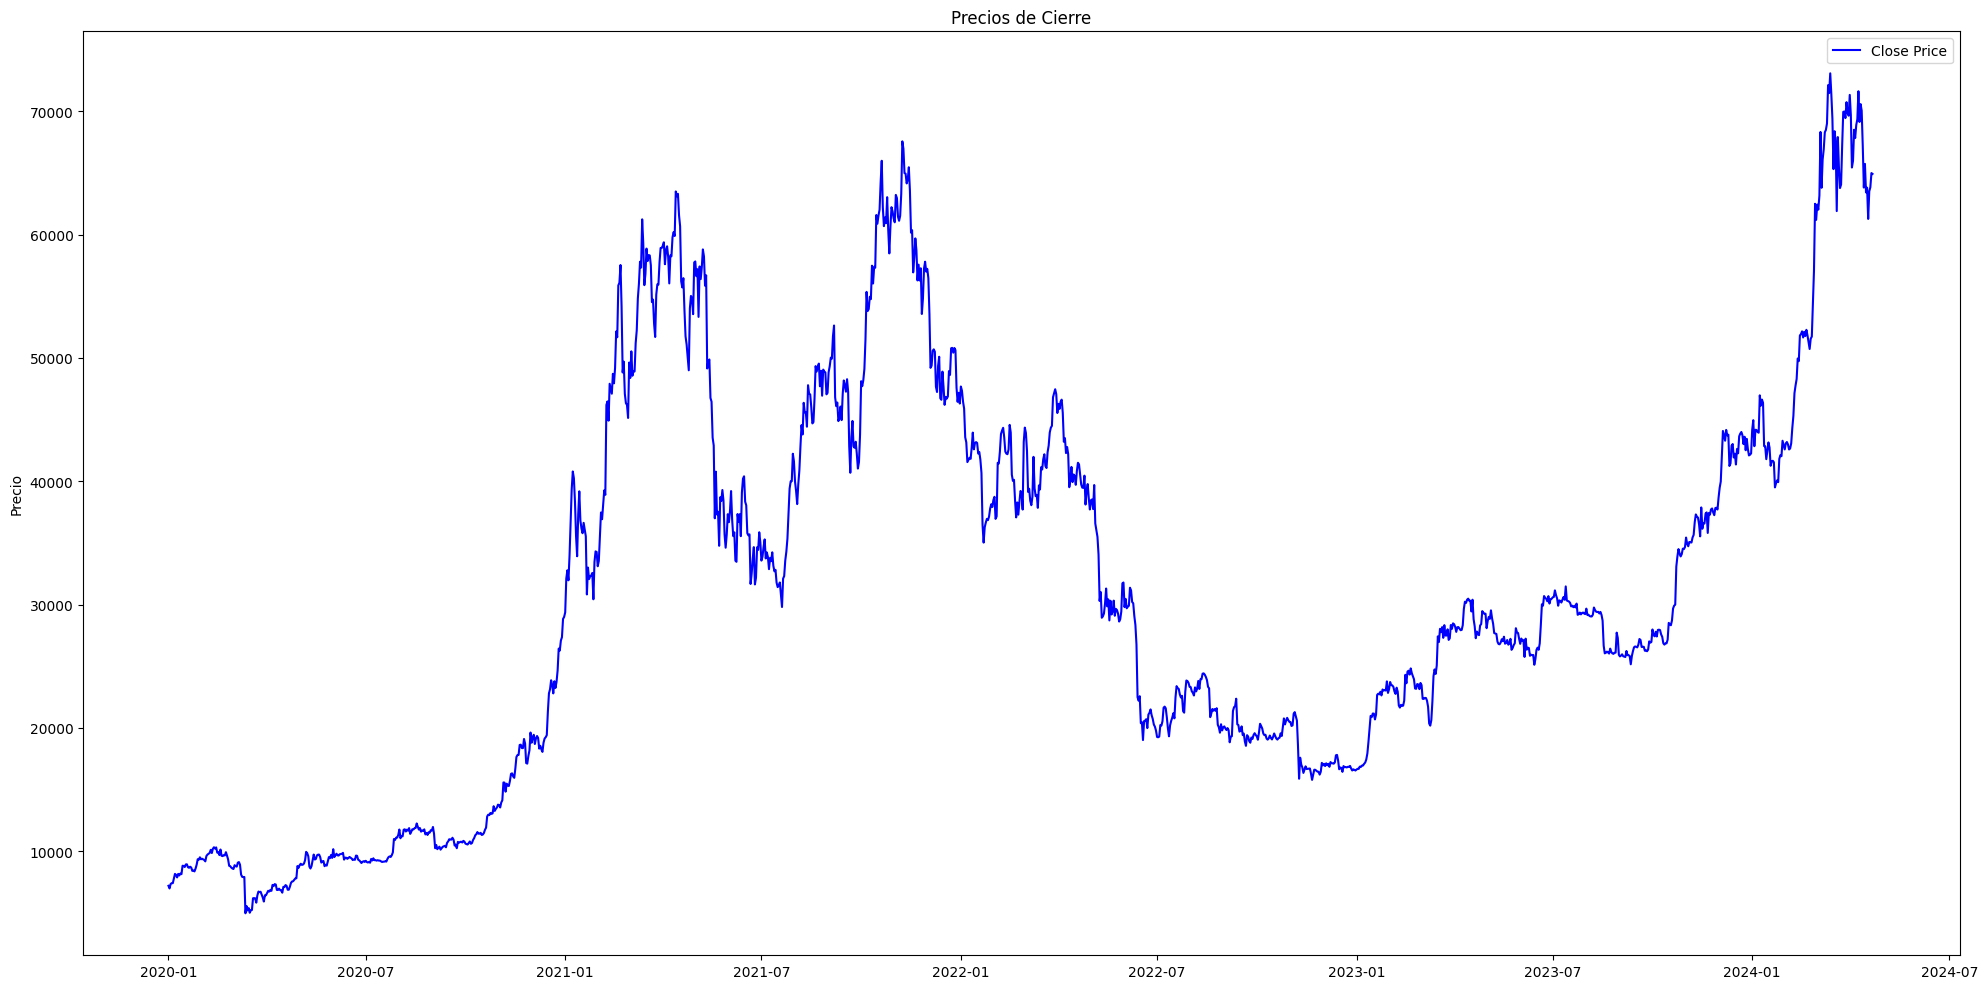

In [46]:
# Visualizacion
plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1, 1, 1)  # Para precios y medias móviles
ax1.plot(data.index, data['Close'], label='Close Price', color='blue')

ax1.set_title('Precios de Cierre')
ax1.set_ylabel('Precio')
ax1.legend()
plt.tight_layout()
plt.show()


## Calculamos Indicadores

In [48]:
# Calcular indicadores
# Añadir medias móviles
data['sma'] = ta.trend.sma_indicator(data['Close'], window=30)
data['ema20'] = ta.trend.ema_indicator(data['Close'], window=20)
data['ema50'] = ta.trend.ema_indicator(data['Close'], window=50)
data['ema200'] = ta.trend.ema_indicator(data['Close'], window=200)


# Añadir RSI
data['rsi'] = ta.momentum.rsi(data['Close'], window=14)

# Añadir MACD
macd = ta.trend.MACD(data['Close'], window_slow=26, window_fast=12, window_sign=9)
data['macd'] = macd.macd()
data['macd_signal'] = macd.macd_signal()

# Añadir Bandas de Bollinger
bollinger = ta.volatility.BollingerBands(data['Close'], window=20, window_dev=2)
data['bollinger_hband'] = bollinger.bollinger_hband()
data['bollinger_lband'] = bollinger.bollinger_lband()
data['bollinger_mavg'] = bollinger.bollinger_mavg()

# Ver los datos con indicadores añadidos
print(data[['Close', 'sma', 'ema', 'rsi', 'macd', 'macd_signal', 'bollinger_hband', 'bollinger_lband', 'bollinger_mavg']].head())

                  Close  sma  ema  rsi  macd  macd_signal  bollinger_hband  \
Date                                                                         
2020-01-01  7200.174316  NaN  NaN  NaN   NaN          NaN              NaN   
2020-01-02  6985.470215  NaN  NaN  NaN   NaN          NaN              NaN   
2020-01-03  7344.884277  NaN  NaN  NaN   NaN          NaN              NaN   
2020-01-04  7410.656738  NaN  NaN  NaN   NaN          NaN              NaN   
2020-01-05  7411.317383  NaN  NaN  NaN   NaN          NaN              NaN   

            bollinger_lband  bollinger_mavg  
Date                                         
2020-01-01              NaN             NaN  
2020-01-02              NaN             NaN  
2020-01-03              NaN             NaN  
2020-01-04              NaN             NaN  
2020-01-05              NaN             NaN  


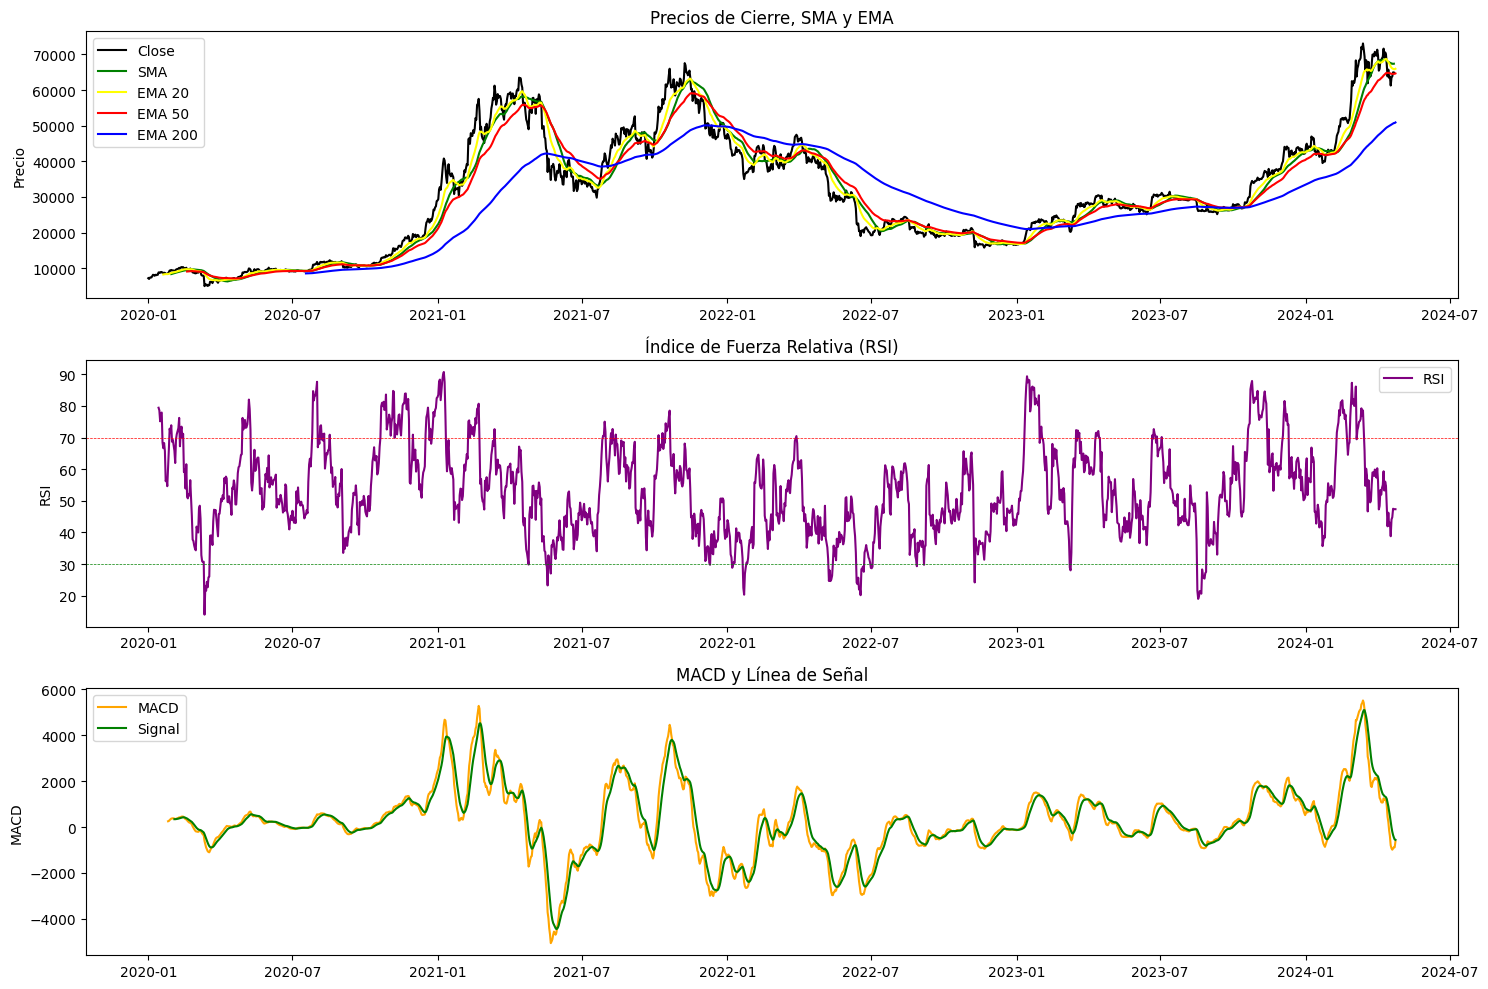

In [50]:
# Configurar el tamaño de la figura
plt.figure(figsize=(15, 10))
# Crear subplots
ax1 = plt.subplot(3, 1, 1)  # Para precios y medias móviles
ax2 = plt.subplot(3, 1, 2, sharex=ax1)  # Para RSI
ax3 = plt.subplot(3, 1, 3, sharex=ax1)  # Para MACD
# Gráfico de precios, SMA y EMA
ax1.plot(data.index, data['Close'], label='Close', color='black')
ax1.plot(data.index, data['sma'], label='SMA', color='green')
ax1.plot(data.index, data['ema20'], label='EMA 20', color='yellow')
ax1.plot(data.index, data['ema50'], label='EMA 50', color='red')
ax1.plot(data.index, data['ema200'], label='EMA 200', color='blue')
ax1.set_title('Precios de Cierre, SMA y EMA')
ax1.set_ylabel('Precio')
ax1.legend()

# Gráfico de RSI
ax2.plot(data.index, data['rsi'], label='RSI', color='purple')
ax2.axhline(70, linestyle='--', color='red', linewidth=0.5)
ax2.axhline(30, linestyle='--', color='green', linewidth=0.5)
ax2.set_title('Índice de Fuerza Relativa (RSI)')
ax2.set_ylabel('RSI')
ax2.legend()

# Gráfico de MACD
ax3.plot(data.index, data['macd'], label='MACD', color='orange')
ax3.plot(data.index, data['macd_signal'], label='Signal', color='green')
ax3.set_title('MACD y Línea de Señal')
ax3.set_ylabel('MACD')
ax3.legend()

# Ajustar el layout y mostrar los gráficos
plt.tight_layout()
plt.show()

In [23]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'